# Классификация отзывов с использованием предварительно обученной языковой модели BERT

**Задача**. Сделать модель для трехклассовой классификации (негативный, нейтральный или положительный) отзывов на платформе TripAdvisor с применением BERT.

Файл с данными "tripadvisor_hotel_reviews.csv" (См. Практику 6.2)



## Этап 1: Сбор и подготовка данных

TripAdvisor предлагает большой объём открытых данных в виде текстовых отзывов, обычно собранных пользователями и содержащих оценки («звёздочки») и комментарии.

Разделите данные на
- **Тренировочную выборку**
- **Тестовую выборку**

Данные представлены в формате пар: `(текст отзыва, оценка)` (например, `"Этот отель прекрасный! Всё идеально.", 5`).
Каждый отзыв имеет пятибальную оценку (1-5). Вам нужно из пятибальной шкалы перейти в трехбальную:

- Положительные отзывы (оценка ≥ 4 звезды);
- Нейтральные отзывы (оценка = 3 звезды);
- Негативные отзывы (оценка ≤ 2 звезды).

Таким образом, задача сводится к трехклассовой классификации.

## Этап 2: Предварительная обработка данных

BERT требует специальной подготовки входных данных перед подачей на вход модели. Сделайте предварительную обработку:

- Токенизация текста с помощью токенизатора BERT.
- Добавление специального символа `[CLS]` в начало каждого примера для обозначения начала последовательности.
- Использование внимания маски (`attention mask`) для разделения значимых и незначимых частей ввода.
- Перевод List в тензоры.


## Этап 3: Настройка и обучение модели

Используйте класс `BertForSequenceClassification` из библиотеки `transformers`, предназначенный специально для задач классификации последовательностей. Учтите, что отзывы могут быть не только на английском языке.

### Выбор гиперпараметров:
- Batch size: число элементов в одном пакете (батче).
- Learning rate: ~ 2e-5.
- Number of epochs: количество эпох (полных проходов по всему набору данных); рекомендуется начинать с 3–4.

## Этап 4: Сделайте оценку результатов.

In [5]:
!pip install -U transformers


In [6]:
import transformers
print(transformers.__version__)
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_WANDB"] = "true"



4.52.3


## Этап 1. Импорт библиотек и проверка устройства

In [7]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Автоматический выбор устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')


Используемое устройство: cuda


## Этап 2. Загрузка и подготовка данных

In [8]:
# Загрузка данных
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
print('Пример данных:')
print(df.head())

# Преобразование рейтинга в три класса
def label_review(rating):
    if rating >= 4:
        return 2  # Положительный
    elif rating == 3:
        return 1  # Нейтральный
    else:
        return 0  # Негативный

df['label'] = df['Rating'].apply(label_review)
print(df['label'].value_counts())

# Деление на train и test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Review'].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label']
)


Пример данных:
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5
label
2    15093
0     3214
1     2184
Name: count, dtype: int64


## Этап 3. Токенизация и подготовка датасета для BERT

In [9]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = BERTDataset(train_texts, train_labels, tokenizer)
test_dataset = BERTDataset(test_texts, test_labels, tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Этап 4. Настройка и обучение модели

In [12]:
from transformers import TrainingArguments, Trainer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to(device)


import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_WANDB"] = "true"


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_steps=50,
    logging_dir=None,
    report_to=[],
    save_strategy="no",
    disable_tqdm=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,

)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer.train()


Step,Training Loss
50,0.749800
100,0.613800
150,0.572600
200,0.538600
250,0.516500
300,0.524700
350,0.397500
400,0.469900
450,0.432800
500,0.432400


TrainOutput(global_step=6147, training_loss=0.3184851462111466, metrics={'train_runtime': 1310.6658, 'train_samples_per_second': 37.52, 'train_steps_per_second': 4.69, 'total_flos': 3234716357548032.0, 'train_loss': 0.3184851462111466, 'epoch': 3.0})

## Этап 5. Оценка результатов и матрица ошибок

Classification report:
                precision    recall  f1-score   support

   Негативный       0.86      0.80      0.83       643
  Нейтральный       0.48      0.51      0.49       437
Положительный       0.94      0.95      0.94      3019

     accuracy                           0.88      4099
    macro avg       0.76      0.75      0.76      4099
 weighted avg       0.88      0.88      0.88      4099



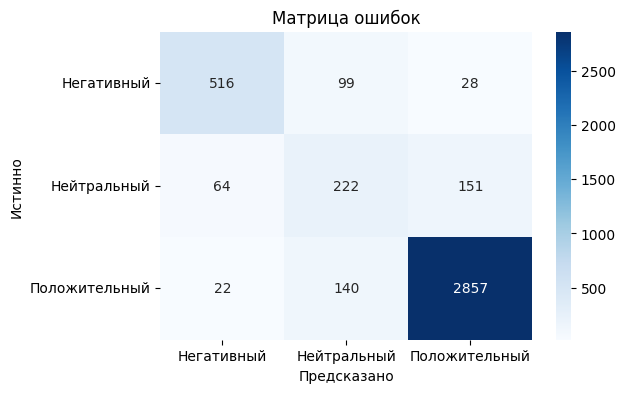

In [14]:

preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = test_labels

print("Classification report:\n", classification_report(y_true, y_pred, target_names=['Негативный', 'Нейтральный', 'Положительный']))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Негативный', 'Нейтральный', 'Положительный'], yticklabels=['Негативный', 'Нейтральный', 'Положительный'])
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()


## Этап 7. Пример предсказания для любого текста

In [16]:

def predict_review(text):
    model.eval()
    with torch.no_grad():
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
        label_dict = {0: 'Негативный', 1: 'Нейтральный', 2: 'Положительный'}
        return label_dict[pred]


print(predict_review("The hotel was clean, staff was friendly and location is perfect!"))
print(predict_review("The hotel was very dirty and the most disgusting I have seen"))


Положительный
Негативный
